<a href="https://colab.research.google.com/github/Rohanjos97/Adversarial_ML_Assignments/blob/lab3/Adversarial_ML_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

## In this assignment you will implement how to perform adversarial attacks using Keras and TensorFlow.

## Q1. The Fast Gradient Sign Method (FGSM),
### a. The one parameter you need to tune which is η
## Q2. IFGSM (PGD),
### a. The one parameter you need to tune which is η
## Q3. CW attack.
### a. The two parameters you need to tune are:
####i. α : Gradient descent step size
####ii. λ : Regularization parameter

## These attacks exploits the gradients of a neural network to build an adversarial image.

## The result is an output image that, according to the human eye, looks identical to the original, but makes the neural network make an incorrect prediction.

## Take 10 sample images for classification using ResNet-50 and show the original class before attack and new class after attack with different hyper parameters value for all 3 attacks given above.

# Comment your observation.

In [ ]:
 
import tensorflow as tf
import keras
import numpy as np
import os

import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
resnet = ResNet50(weights='imagenet')

for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# resnet.summary()

'''
OUTPUT

Total params: 25,636,712
Trainable params: 0
Non-trainable params: 25,636,712
'''

'\nOUTPUT\n\nTotal params: 25,636,712\nTrainable params: 0\nNon-trainable params: 25,636,712\n'

## The sample images choosen for classification

1/1 [==============================] - 0s 211ms/step


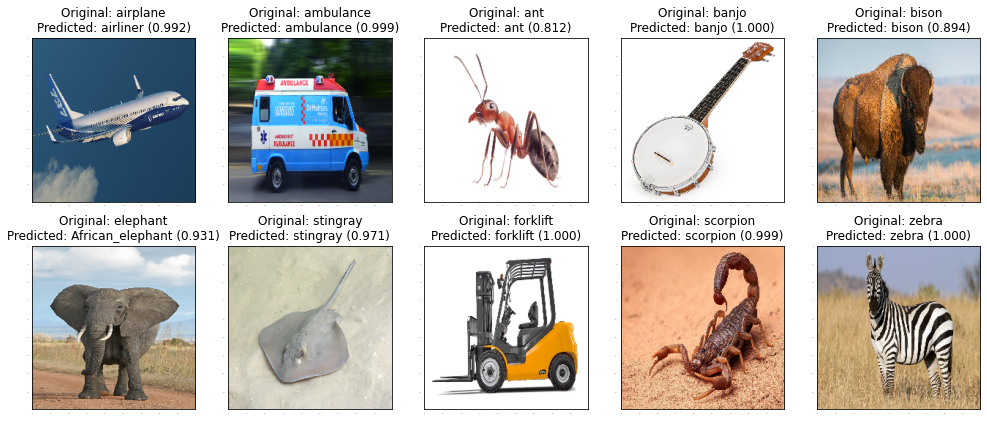

In [ ]:
# Loading the image and pre-processing it for ResNet50 model
image_name = ['airplane', 'ambulance', 'ant', 'banjo', 'bison', 'elephant', 'stingray', 'forklift', 'scorpion', 'zebra']

fig, axes = plt.subplots(2, 5, figsize=(17, 7))

for ind, img_name in enumerate(image_name):
  img_path = os.path.join('/content/sample_images/', img_name + '.jpg')
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)
  x = x.astype(np.uint8)

  # Predictions on images
  pred = resnet.predict(x)
  pred = decode_predictions(pred, top=1)[0]

  axes[int(ind/5), int(ind%5)].imshow(x[0])
  axes[int(ind/5), int(ind%5)].set_title(f'Original: {img_name}\nPredicted: {pred[0][1]} ({pred[0][2]:0.3f})')
  axes[int(ind/5), int(ind%5)].tick_params(which='both', size=0, labelsize=0)

# 1. FGSM (Fast Gradient Sign Method)

In [ ]:
loss_object = CategoricalCrossentropy()

# Function to calculate the gradient of the loss function w.r.t. image
def create_adversarial_pattern(input_image, input_label):
  input_image = tf.convert_to_tensor(input_image, dtype='float64')

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = resnet(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)

  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

1/1 [==============================] - 0s 203ms/step


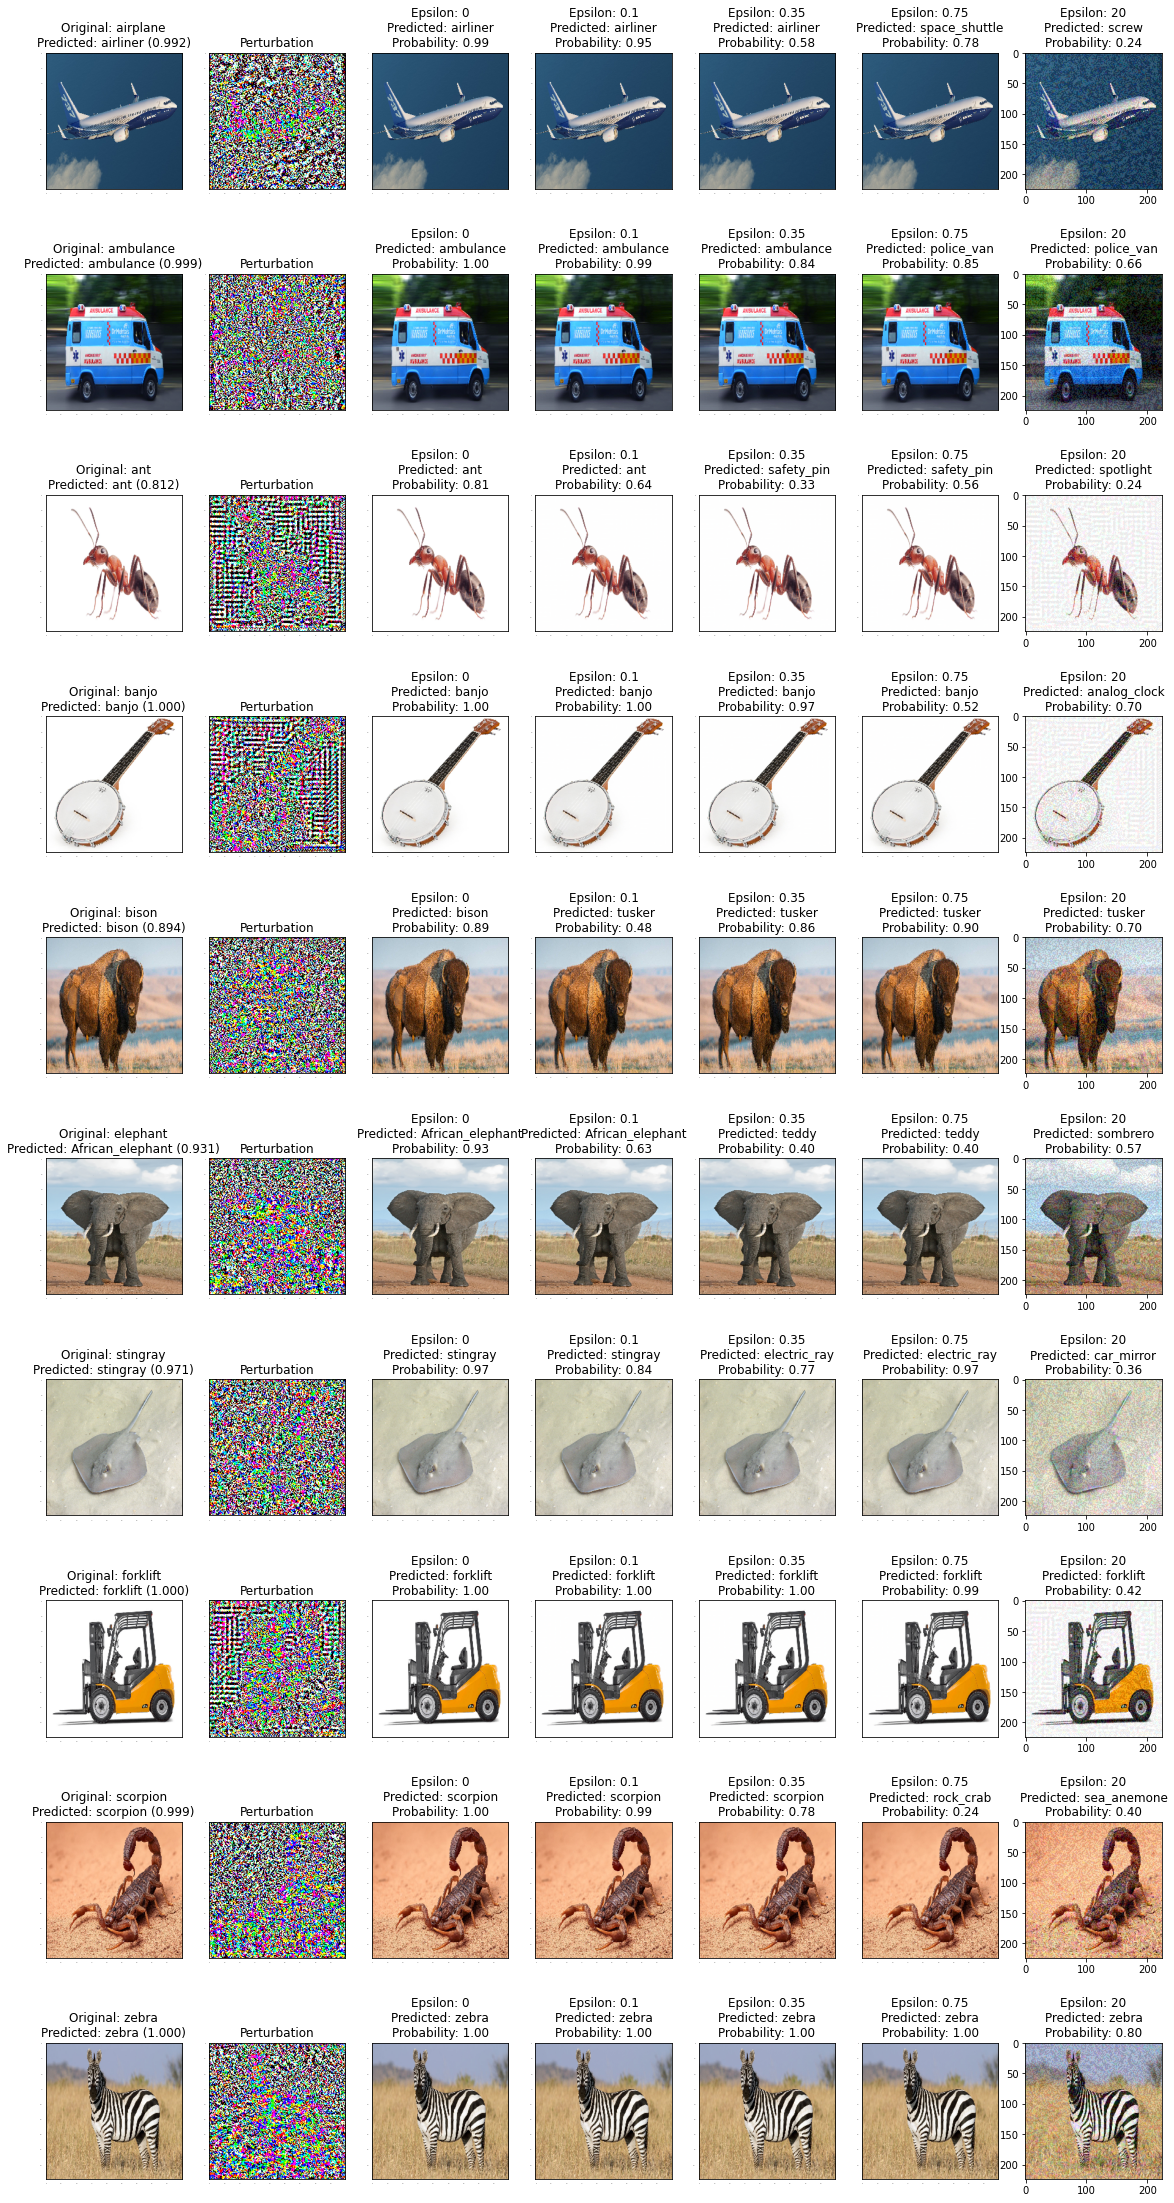

In [ ]:
image_name = ['airplane', 'ambulance', 'ant', 'banjo', 'bison', 'elephant', 'stingray', 'forklift', 'scorpion', 'zebra']

fig, axes = plt.subplots(10, 7, figsize=(20, 40))

# Iterate for every image in sample
for ind, img_name in enumerate(image_name):
  
  # Load image and transform it for input to resnet50 model
  img_path = os.path.join('/content/sample_images/', img_name + '.jpg')
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x.astype(np.uint8)

  # Predictions on original image
  pred = resnet.predict(x)
  pred = np.array(pred)

  pred_val = decode_predictions(np.array(pred), top=1)
  # if ind == 0:
    # print(np.array(pred)[0].argmax())

  # Convert output to one hot vector
  pred_index = pred[0].argmax() # get the index of correct prediction
  label = tf.one_hot(pred_index, pred.shape[-1]) # correct prediction index get '1', other classes gets '0' in the one hot vector
  label = tf.reshape(label, (1, pred.shape[-1]))
  perturbations = create_adversarial_pattern(x, label)

  epsilons = [0, 0.1, 0.35, 0.75, 20]

  axes[ind, 0].imshow(x[0])
  axes[ind, 0].set_title(f'Original: {img_name}\nPredicted: {pred_val[0][0][1]} ({pred_val[0][0][2]:0.3f})')

  axes[ind, 1].imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] sign values to [0,1]
  axes[ind, 1].set_title('Perturbation')

  for eps_ind, eps in enumerate(epsilons):
    perturbations = np.array(perturbations)
    adv_x = np.float64(x) + (eps * perturbations)
    adv_x = np.clip(adv_x, 0, 255)
    adv_x = adv_x.astype(np.float64)
    # print(adv_x)
    
    # Get the prediction on adversarial image
    adv_pred = resnet.predict(adv_x)
    adv_pred = np.array(adv_pred)
    adv_pred_val = decode_predictions(np.array(adv_pred), top=1)

    axes[ind, 2 + eps_ind].imshow(np.uint8(adv_x[0]))
    axes[ind, 2 + eps_ind].set_title(f'Epsilon: {eps}\nPredicted: {adv_pred_val[0][0][1]}\nProbability: {adv_pred_val[0][0][2]:0.2f}')

  # Remove x and y scales
  axes[ind, 0].tick_params(which='both', size=0, labelsize=0)
  axes[ind, 1].tick_params(which='both', size=0, labelsize=0)
  axes[ind, 2].tick_params(which='both', size=0, labelsize=0)
  axes[ind, 3].tick_params(which='both', size=0, labelsize=0)
  axes[ind, 4].tick_params(which='both', size=0, labelsize=0)
  axes[ind, 5].tick_params(which='both', size=0, labelsize=0)